<a href="https://colab.research.google.com/github/ThilakBS/GTech-Seth-Bonder/blob/main/SBCDL_Time_Series_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This project is about predicting the temperature 12 hours from now given a set of past features. The data is from Germany for about 7 years at the hourly granularity

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import timeseries_dataset_from_array
import numpy as np
from matplotlib import pyplot as plt
import os

# Read the data from the csv file (do not worry); the header gives you the meaning of the features

In [ ]:
fname = os.path.join("jena_climate_2009_2016.csv")
with open(fname) as f:
    data = f.read()
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


# These lines compute the temperature (the target) and the raw_data (the features). The raw_data also contains the temperature since past temperature will be used to predict the next temperature

In [ ]:
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

# Normalize the raw data

In [ ]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

# Define the proper number of samples for the training, testing, and validation sets; do not create new sets

In [ ]:
num_train_samples = 30000
num_val_samples = 10000
num_test_samples = 10000
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
print("total:",num_train_samples + num_val_samples + num_test_samples)

num_train_samples: 30000
num_val_samples: 10000
num_test_samples: 10000
total: 50000


# This is the utility code to generate the data as discussed in the videos

In [ ]:
sequence_length = 120
lookahead = 12 # predict 12 hours in the future
delay = (sequence_length + lookahead - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples-1)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples-1)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples,
    end_index=num_train_samples + num_val_samples + num_test_samples-delay-1)


# Now define the DNN model, plot the results;

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(64)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=100,
                    validation_data=val_dataset)

Epoch 1/800
117/117 [==============================] - 7s 56ms/step - loss: 21.2050 - mae: 3.5717 - val_loss: 11.4160 - val_mae: 2.7801
Epoch 2/800
117/117 [==============================] - 5s 43ms/step - loss: 10.2195 - mae: 2.4633 - val_loss: 6.7522 - val_mae: 2.0886
Epoch 3/800
117/117 [==============================] - 5s 47ms/step - loss: 9.1061 - mae: 2.1735 - val_loss: 5.2429 - val_mae: 1.8048
Epoch 4/800
117/117 [==============================] - 5s 42ms/step - loss: 8.4570 - mae: 2.0377 - val_loss: 4.3433 - val_mae: 1.6492
Epoch 5/800
117/117 [==============================] - 7s 56ms/step - loss: 8.4101 - mae: 1.9720 - val_loss: 4.6617 - val_mae: 1.7282
Epoch 6/800
117/117 [==============================] - 5s 43ms/step - loss: 8.1029 - mae: 1.9339 - val_loss: 4.7310 - val_mae: 1.7383
Epoch 7/800
117/117 [==============================] - 6s 55ms/step - loss: 7.4423 - mae: 1.8764 - val_loss: 4.9443 - val_mae: 1.8166
Epoch 8/800
117/117 [==============================] - 5s 4

KeyboardInterrupt: 

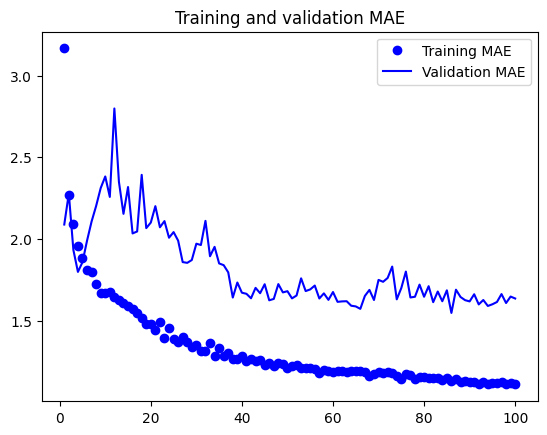

In [ ]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()